<a href="https://colab.research.google.com/github/hsss/pytorch_tutorial/blob/master/20190717_semi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch tutorial 20190717

![대체 텍스트](https://docs.google.com/uc?export=download&id=1PGtI-970IU8LD_yk0umiFEfhAcTVpT7-)

In [1]:
import torch

print(torch.cuda.is_available())

True


In [2]:
x = torch.rand(1, 3)
print(x.size())

y = torch.rand(3, 1)
print(y.size())

result = torch.mm(x, y)
print(result)
print(result.size())

torch.Size([1, 3])
torch.Size([3, 1])
tensor([[0.6961]])
torch.Size([1, 1])


In [3]:
print(result.device)

cpu


In [4]:
device = torch.device('cuda')
x = x.to(device)
y = y.to(device)

result = torch.mm(x, y)

print(result)
print(result.device)

tensor([[0.6961]], device='cuda:0')
cuda:0


In [5]:
%pylab inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision import datasets, transforms

SEED = 1

# For reproducibility
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

Populating the interactive namespace from numpy and matplotlib


![대체 텍스트](https://docs.google.com/uc?export=download&id=1RV3KJJGtp3l6mBdT7Wg8f2wkzf5MuCpC)

# dataset code 예시 

In [0]:
class MNIST(data.Dataset):
    """`MNIST <http://yann.lecun.com/exdb/mnist/>`_ Dataset.

    Args:
        root (string): Root directory of dataset where ``processed/training.pt``
            and  ``processed/test.pt`` exist.
        train (bool, optional): If True, creates dataset from ``training.pt``,
            otherwise from ``test.pt``.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """
    urls = [
        'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz',
    ]
    training_file = 'training.pt'
    test_file = 'test.pt'
    classes = ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four',
               '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

    @property
    def train_labels(self):
        warnings.warn("train_labels has been renamed targets")
        return self.targets

    @property
    def test_labels(self):
        warnings.warn("test_labels has been renamed targets")
        return self.targets

    @property
    def train_data(self):
        warnings.warn("train_data has been renamed data")
        return self.data

    @property
    def test_data(self):
        warnings.warn("test_data has been renamed data")
        return self.data

    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')

        if self.train:
            data_file = self.training_file
        else:
            data_file = self.test_file
        self.data, self.targets = torch.load(os.path.join(self.processed_folder, data_file))

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)

    @property
    def raw_folder(self):
        return os.path.join(self.root, self.__class__.__name__, 'raw')

    @property
    def processed_folder(self):
        return os.path.join(self.root, self.__class__.__name__, 'processed')

    @property
    def class_to_idx(self):
        return {_class: i for i, _class in enumerate(self.classes)}

    def _check_exists(self):
        return os.path.exists(os.path.join(self.processed_folder, self.training_file)) and \
            os.path.exists(os.path.join(self.processed_folder, self.test_file))

    @staticmethod
    def extract_gzip(gzip_path, remove_finished=False):
        print('Extracting {}'.format(gzip_path))
        with open(gzip_path.replace('.gz', ''), 'wb') as out_f, \
                gzip.GzipFile(gzip_path) as zip_f:
            out_f.write(zip_f.read())
        if remove_finished:
            os.unlink(gzip_path)

    def download(self):
        """Download the MNIST data if it doesn't exist in processed_folder already."""

        if self._check_exists():
            return

        makedir_exist_ok(self.raw_folder)
        makedir_exist_ok(self.processed_folder)

        # download files
        for url in self.urls:
            filename = url.rpartition('/')[2]
            file_path = os.path.join(self.raw_folder, filename)
            download_url(url, root=self.raw_folder, filename=filename, md5=None)
            self.extract_gzip(gzip_path=file_path, remove_finished=True)

        # process and save as torch files
        print('Processing...')

        training_set = (
            read_image_file(os.path.join(self.raw_folder, 'train-images-idx3-ubyte')),
            read_label_file(os.path.join(self.raw_folder, 'train-labels-idx1-ubyte'))
        )
        test_set = (
            read_image_file(os.path.join(self.raw_folder, 't10k-images-idx3-ubyte')),
            read_label_file(os.path.join(self.raw_folder, 't10k-labels-idx1-ubyte'))
        )
        with open(os.path.join(self.processed_folder, self.training_file), 'wb') as f:
            torch.save(training_set, f)
        with open(os.path.join(self.processed_folder, self.test_file), 'wb') as f:
            torch.save(test_set, f)

        print('Done!')

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train is True else 'test'
        fmt_str += '    Split: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

# 예시 종료

In [6]:
MNIST_train = datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))

0it [00:00, ?it/s]

9920512it [00:01, 8704261.58it/s]                            


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 133841.04it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2191903.61it/s]                            
0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 50390.60it/s]            


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


(28, 28)
7


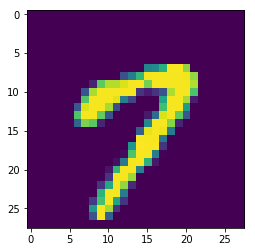

In [7]:
example, label = MNIST_train.__getitem__(15)
example = np.array(example, np.float32)[0]

print(example.shape)
print(label)

plt.imshow(example)

In [0]:
MNIST_test = datasets.MNIST('../data', train=False,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))

![대체 텍스트](https://docs.google.com/uc?export=download&id=1HDsCgeMOSqPaVsJ-EuJwMylMsE_FczJ-)

![대체 텍스트](https://docs.google.com/uc?export=download&id=1X8rT8qexqO1p55gkTJJO1ce_trmb-EhY)

![대체 텍스트](https://docs.google.com/uc?export=download&id=1wfnkDWUbm7a4fsn_uSph3csn4OQT9dO1)

In [0]:
train_loader = torch.utils.data.DataLoader(
        MNIST_train,
        batch_size=50, shuffle=True, 
        num_workers=1,
		    pin_memory=True,
		    drop_last=True)
#worker_init_fn=worker_init_fn)

test_loader = torch.utils.data.DataLoader(
        MNIST_test,
        batch_size=50, shuffle=False,
        num_workers=1,
		    pin_memory=True,
		    drop_last=False)



# Network 정의

In [29]:
# One hidden Layer NN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        #print(x.size())
        #print(x)
        
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) 
    
    
model = Net()
example, label = MNIST_train.__getitem__(15)
example = example.reshape(1, 1, 28, 28)
print('===========In-Network')
output = model(example)
print('===========Out-Network')
print(output)
print(output.size())


===========In-Network
===========Out-Network
tensor([[-2.3591, -2.3340, -2.2623, -2.5139, -2.2570, -2.4223, -2.3073, -2.2669,
         -2.2763, -2.0848]], grad_fn=<LogSoftmaxBackward>)
torch.Size([1, 10])


![대체 텍스트](https://docs.google.com/uc?export=download&id=1HuKKyyCdEPau7mGP877nlp4kwXDMIEH7)

In [19]:
for name, param in model.named_parameters():
  print(name)
  #print(param)
  
model.train()
model.eval()

conv1.weight
conv1.bias
conv2.weight
conv2.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias


In [30]:
model.to('cuda')

example = example.to('cuda')

output = model(example)
print(output)

tensor([[-2.3591, -2.3340, -2.2623, -2.5139, -2.2570, -2.4223, -2.3073, -2.2669,
         -2.2763, -2.0848]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)


In [32]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)


EPOCHS = 5
losses = []

model.train()

    
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to('cuda'), target.to('cuda')
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

            
            
print('TRAINING DONE!!!!')


Train Epoch: 0 [0/60000 (0%)]	Loss: 0.000144
Train Epoch: 0 [25000/60000 (42%)]	Loss: 0.038634
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.001343
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.063566
Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.168720
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.025827
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.007735
Train Epoch: 2 [25000/60000 (42%)]	Loss: 0.000258
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.000257
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.009096
Train Epoch: 3 [25000/60000 (42%)]	Loss: 0.001638
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.000054
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.000378
Train Epoch: 4 [25000/60000 (42%)]	Loss: 0.026494
Train Epoch: 4 [50000/60000 (83%)]	Loss: 0.000231


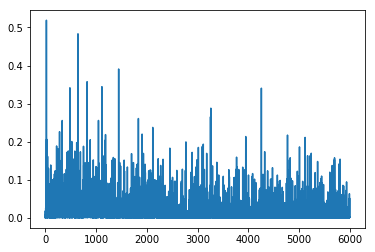

In [33]:
plt.plot(losses)

In [34]:
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to('cuda'), target.to('cuda')
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


Test set: Average loss: 0.0313, Accuracy: 9911/10000 (99%)

